In [ ]:
import transformers
print(transformers.__version__)

4.38.2


In [ ]:
model_checkpoint = "antoineedy/stanford-deidentifier-base-finetuned-ner"
batch_size = 16

In [ ]:
from datasets import load_dataset, load_metric

In [ ]:
datasets = load_dataset("surrey-nlp/PLOD-CW")

In [ ]:
TEXT2ID = {
    "B-O": 0,
    "B-AC": 1,
    "B-LF": 2,
    "I-LF": 3,
}

datasets = datasets.map(lambda x: {"ner_tags": [TEXT2ID[tag] for tag in x["ner_tags"]]})

In [ ]:
label_list = list(set(datasets["train"]['ner_tags'][0]))
label_list

[0, 1, 2, 3]

In [ ]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/706k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [ ]:
label_all_tokens = True

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"{ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
tokenized_datasets = datasets.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/1072 [00:00<?, ? examples/s]

Map:   0%|          | 0/126 [00:00<?, ? examples/s]

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list), ignore_mismatched_sizes=True)

config.json:   0%|          | 0.00/902 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-ner",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=60,
    weight_decay=0.01,
    push_to_hub=True,
)

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

In [ ]:
metric = load_metric("seqeval")

<ipython-input-32-e20ba34f8cc7>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
example = datasets["train"][0]
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
tokens

['[CLS]',
 'for',
 'this',
 'purpose',
 'the',
 'got',
 '##hen',
 '##burg',
 'young',
 'persons',
 'empowerment',
 'scale',
 '(',
 'gy',
 '##pes',
 ')',
 'was',
 'developed',
 '.',
 '[SEP]']

In [ ]:
labels = [label_list[i] for i in example[f"{ner_tags"]]
metric.compute(predictions=[labels], references=[labels])

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 2 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 3 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, 

{'overall_precision': 0.0,
 'overall_recall': 0.0,
 'overall_f1': 0.0,
 'overall_accuracy': 1.0}

In [ ]:
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

from sklearn.metrics import classification_report
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    tp = []
    for l in true_predictions:
        tp += l
    tl = []
    for l in true_labels:
        tl += l

    cr = classification_report(tl, tp, output_dict=True)
    out = {}
    for key in cr.keys():
        if key == 'accuracy':
            out[key] = cr[key]
        else:
            for new_k in ['precision', 'recall', 'f1-score']:
                out[key+'_'+new_k] = cr[key][new_k]
    return out

Note that we drop the precision/recall/f1 computed for each category and only focus on the overall precision/recall/f1/accuracy.

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [ ]:
import torch
from torch import nn

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        w3 = [0.0443, 0.6259, 1.0000, 0.4525]
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(w3).to(logits.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


We can now finetune our model by just calling the `train` method:

In [ ]:
#trainer.train()

In [ ]:
#!zip -r test.zip /content/distilbert-base-uncased-finetuned-ner/checkpoint-2000/

In [ ]:
#from google.colab import files
#files.download('/content/test.zip')

The `evaluate` method allows you to evaluate again on the evaluation dataset or on another dataset:

In [ ]:
#trainer.evaluate()

To get the precision/recall/f1 computed for each category now that we have finished training, we can apply the same function as before on the result of the `predict` method:

In [ ]:
predictions, labels, _ = trainer.predict(tokenized_datasets["validation"])
predictions = np.argmax(predictions, axis=2)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

results = metric.compute(predictions=true_predictions, references=true_labels)
results

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 2 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 3 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: 1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, 

{'overall_precision': 0.0,
 'overall_recall': 0.0,
 'overall_f1': 0.0,
 'overall_accuracy': 0.950698003180774}

In [ ]:
print(true_labels)

labels = []
for l in true_labels:
  labels+=l
pred = []
for l in true_predictions:
  pred += l

ID2TEXT = {
    0: "B-O",
    1: "B-AC",
    2: "B-LF",
    3: "I-LF"
}
TEXT2ID = {v: k for k, v in ID2TEXT.items()}
labels = [ID2TEXT[k] for k in labels]
pred = [ID2TEXT[k] for k in pred]
print(labels)

[[0, 2, 3, 3, 3, 0, 1, 0, 2, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 3, 3, 3, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 3, 3, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 3, 3, 3, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 2, 3, 3, 0, 1, 0, 0, 2, 3, 3, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0

In [ ]:
import matplotlib.font_manager
fpaths = matplotlib.font_manager.findSystemFonts()

for i in fpaths:
    f = matplotlib.font_manager.get_font(i)
    print(f.family_name)

Liberation Serif
Liberation Mono
Liberation Serif
Liberation Serif
Liberation Sans Narrow
Liberation Sans Narrow
Humor Sans
Liberation Sans Narrow
Liberation Sans
Liberation Mono
Liberation Serif
Liberation Sans
Liberation Sans Narrow
Liberation Sans
Liberation Sans
Liberation Mono
Liberation Mono


['B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-AC', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-AC', 'B-AC', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-AC', 'B-O',

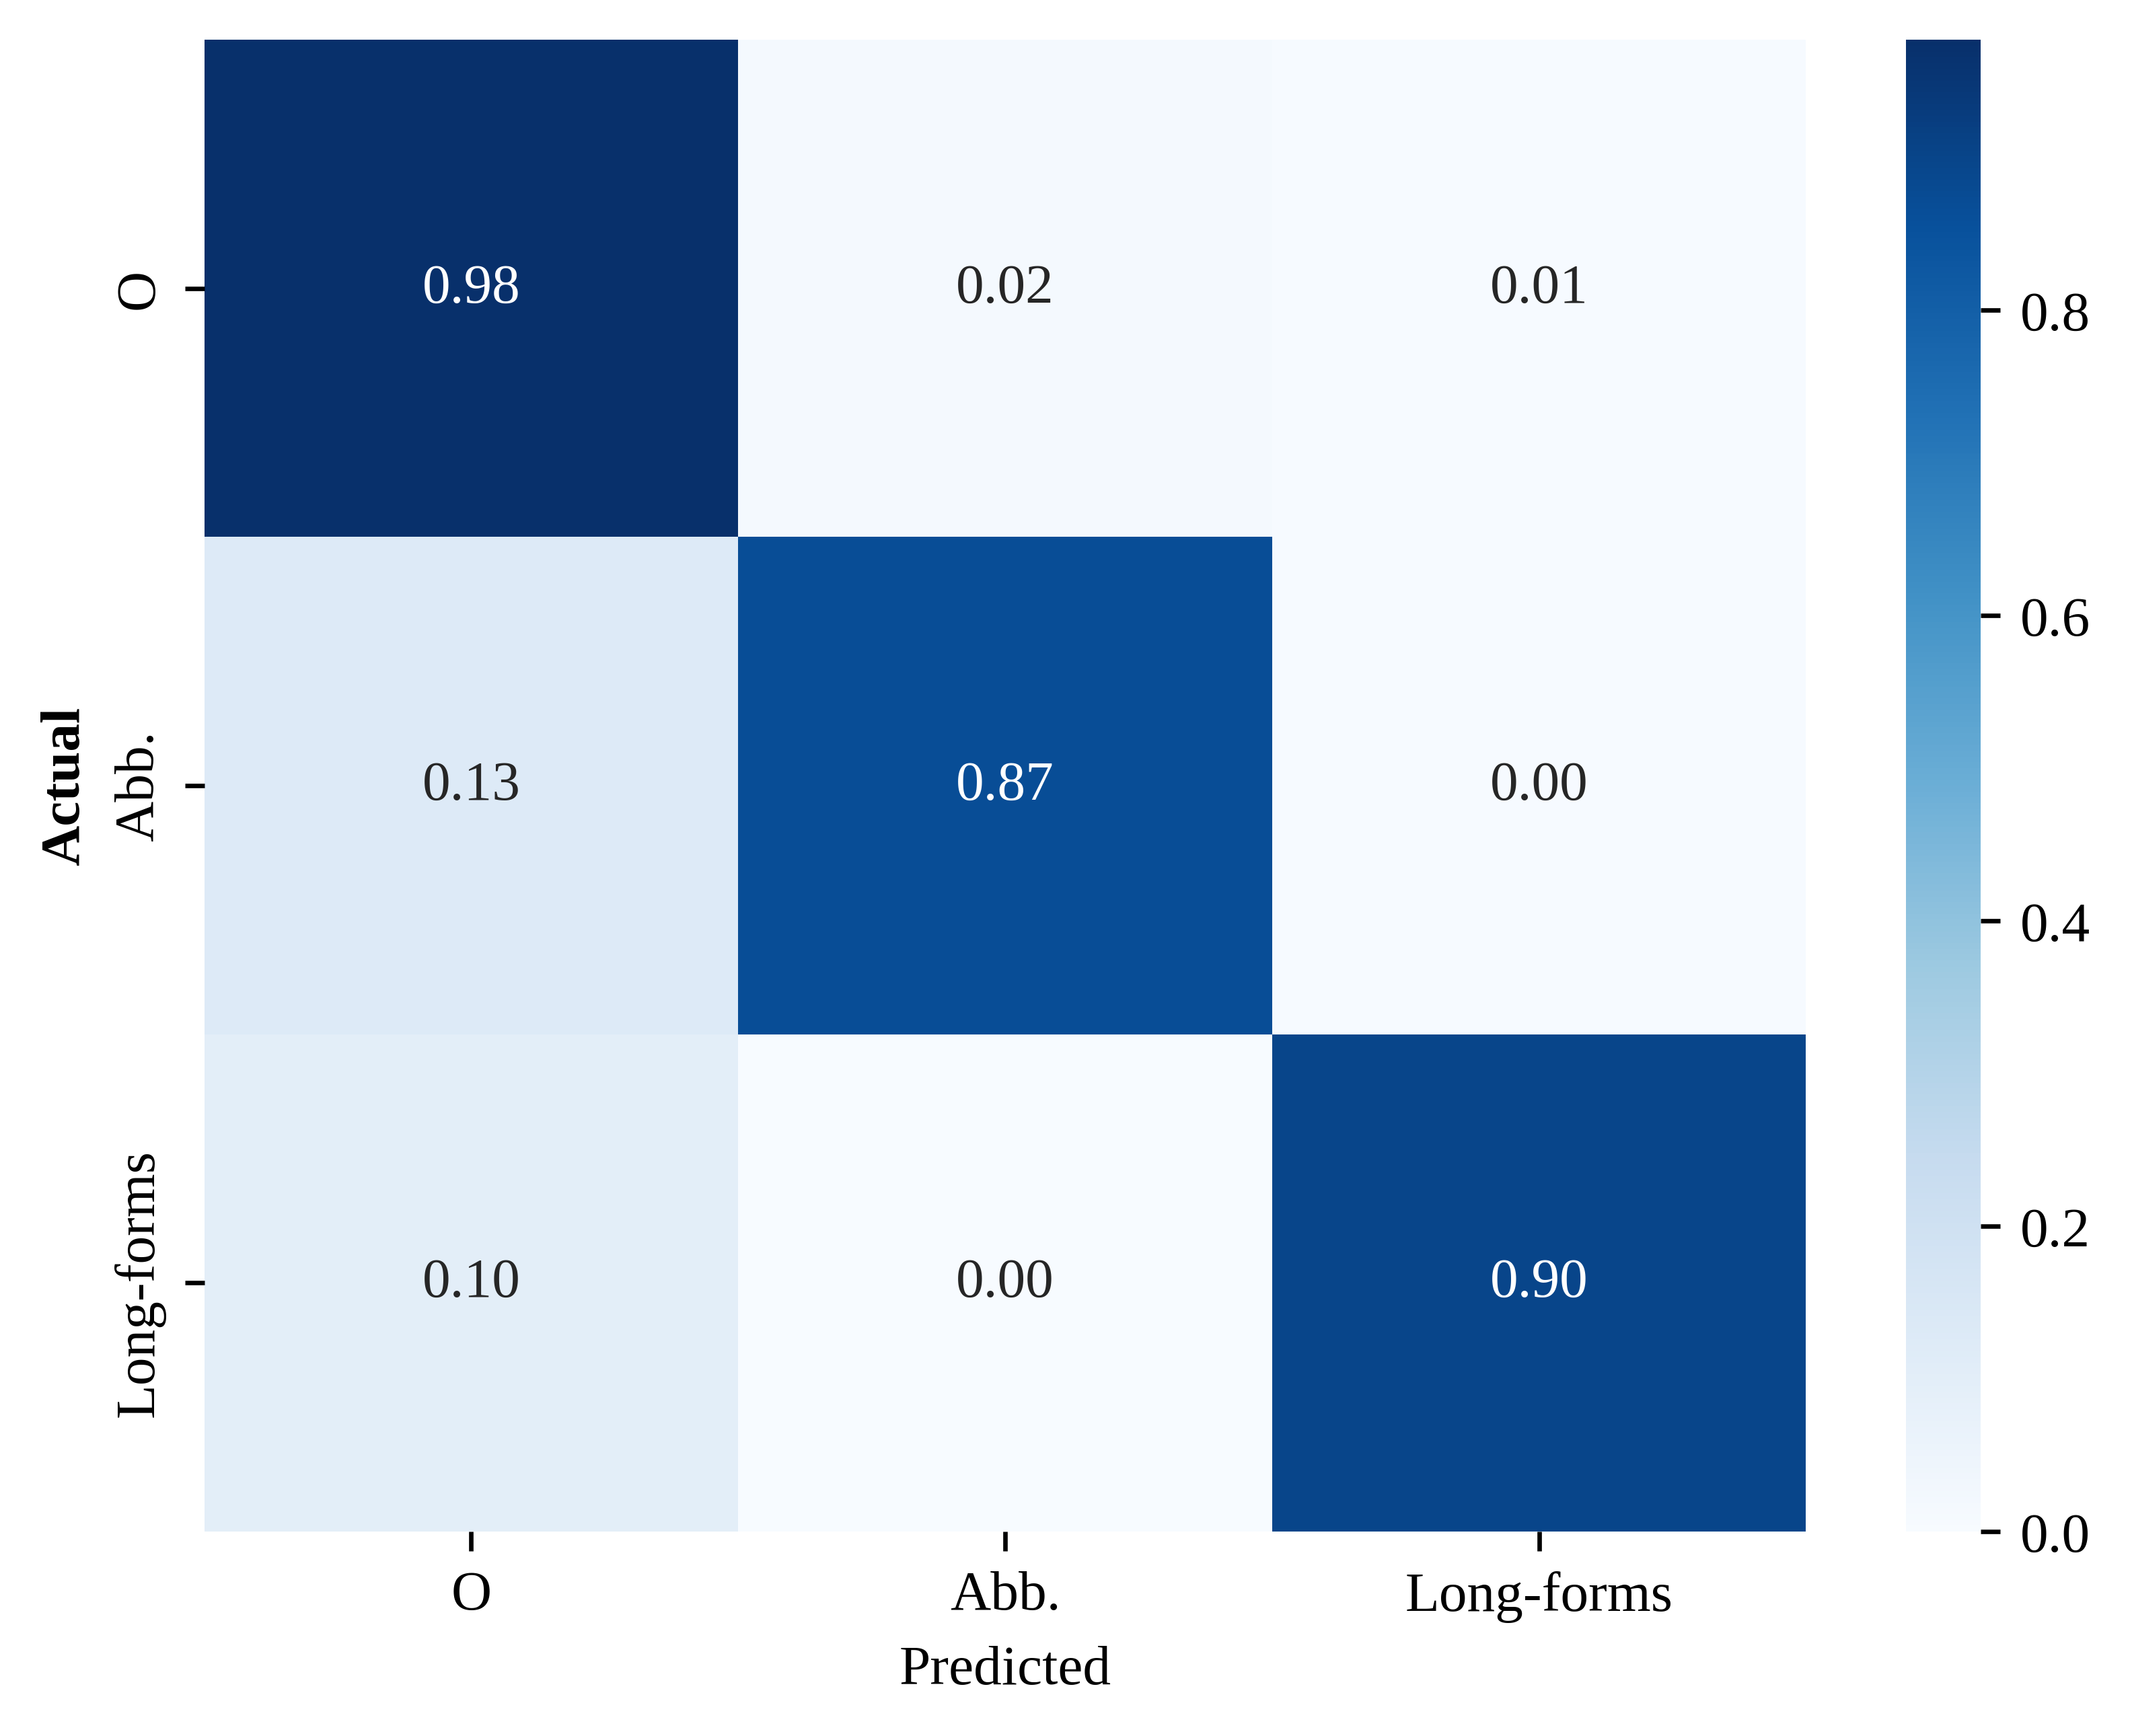

In [ ]:
# confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

alabels = ['B-O', 'B-AC', 'B-LF']
nlabels = ['O', 'Abb.', 'Long-forms']

c = labels
p = pred

print(c, '\n', p)

cm = confusion_matrix(c, p, normalize='true', labels =alabels)

plt.style.use('default')

plt.figure(dpi=600)

# change font to scientific
plt.rcParams['font.family'] = 'Liberation Serif'

sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=nlabels, yticklabels=nlabels, fmt=".2f")
#make labels bold
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted')
plt.show()

You can now upload the result of the training to the Hub, just execute this instruction:

In [ ]:
trainer.push_to_hub("new_test")

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("sgugger/my-awesome-model")
```